In [1]:
from utils import get_file_paths, get_training_files_paths, gray_svd_decomposition
# from losses import focal_tversky

from tf_model_related import AttentionUnet, Losses
from preprocessing import orthosSequence#  LoadPreprocessImages

import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import numpy as np
import cv2 
from skimage import color

# import tensorflow as tf 
from tensorflow import keras
# from tensorflow.keras.preprocessing.image import load_img
from keras import backend as K

from sklearn.model_selection import train_test_split

from segmentation_mask_overlay import overlay_masks

In [2]:
with open('config.json') as f:
    config = json.load(f)

In [3]:
epochnum = 30
test_split = 0.1
img_size = 256
batch_size = 64

In [4]:
max_samples = 5000
divide_by_dept = True

In [5]:
input_img_paths, target_img_paths = get_file_paths(divide_by_dept=divide_by_dept)

In [6]:
img_paths, mask_paths = get_training_files_paths(input_img_paths, target_img_paths, max_samples=max_samples)

In [7]:
import pandas as pd
import os
pd.Series(img_paths).apply(lambda x: os.path.basename(x)[4:6]).value_counts()#.sum()

14    1250
35    1250
49    1250
61    1250
Name: count, dtype: int64

In [8]:
train_input_img_paths, val_input_img_paths, train_target_img_paths, val_target_img_paths = train_test_split(img_paths, mask_paths, test_size=test_split, shuffle=True)

In [9]:
# Instantiate data Sequences for each split
train_gen = orthosSequence(batch_size=batch_size, input_img_paths=train_input_img_paths, target_img_paths=train_target_img_paths, rgb=False, add_noise=True)
val_gen = orthosSequence(batch_size=batch_size, input_img_paths=val_input_img_paths, target_img_paths=val_target_img_paths, rgb=False, add_noise=True)

In [10]:
train_gen.__getitem__(0)[0].shape

(64, 256, 256, 1)

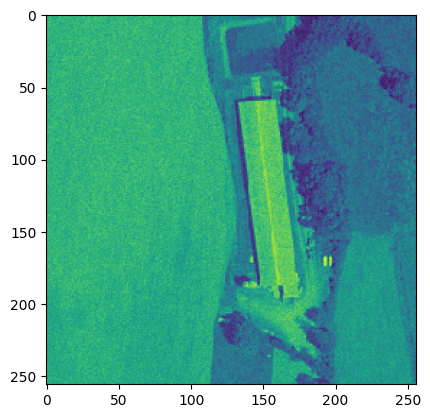

In [11]:
plt.imshow(val_gen.__getitem__(0)[0][0])#[:100, :100]

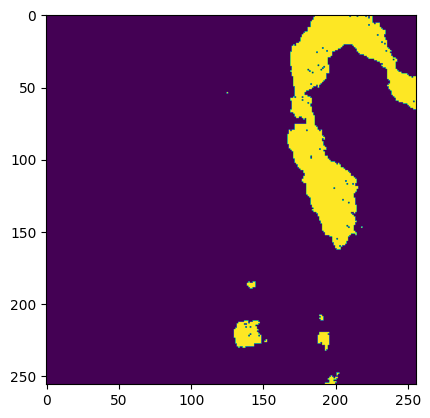

In [12]:
plt.imshow(val_gen.__getitem__(0)[1][0])

In [13]:
from IPython.display import clear_output

class PerformancePlotCallback(keras.callbacks.Callback):
    def __init__(self, val_gen):
        self.imgs = val_gen.__getitem__(1)[0]
        self.trues = val_gen.__getitem__(1)[1]
        
    def on_epoch_end(self, epoch, logs={}):
        # clear_output(wait=True)
        y_preds = self.model.predict(self.imgs)
        plt.figure(figsize=(12, 12))

        title = ["Input Image", "True Mask", "Predicted Mask"]
        display_list = [self.imgs[0], self.trues[0], np.round(y_preds[0])]
        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i + 1)
            plt.title(title[i])
            plt.imshow(keras.utils.array_to_img(display_list[i]))
            plt.axis("off")
        plt.show()
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))

In [16]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
attention_unet = AttentionUnet((config['img_size'], config['img_size']) + (1,))
model = attention_unet.build_model()

In [17]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv1_1 (Conv2D)            (None, 256, 256, 32)         320       ['input_1[0][0]']             
                                                                                                  
 conv1_1_bn (BatchNormaliza  (None, 256, 256, 32)         128       ['conv1_1[0][0]']             
 tion)                                                                                            
                                                                                                  
 conv1_1_act (Activation)    (None, 256, 256, 32)         0         ['conv1_1_bn[0][0]']      

In [18]:
LR = 1e-3

model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), loss=Losses.focal_tversky, metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.IoU(num_classes=2, target_class_ids=[1])])
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), loss=Combo_loss, metrics=[keras.metrics.BinaryAccuracy()])
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), loss=keras.losses.BinaryCrossentropy(), metrics=[keras.metrics.BinaryAccuracy()])
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), loss=keras.losses.BinaryFocalCrossentropy(), metrics=[keras.metrics.BinaryAccuracy()])

callbacks = [
    PerformancePlotCallback(val_gen),
    keras.callbacks.EarlyStopping(patience=5, start_from_epoch=5),
    keras.callbacks.ModelCheckpoint(config['models_dir']+f"35_14_61_49/1993/intermediary_AttentionUnet_B&W_{int(len(train_input_img_paths))}_trains_10e_4_gaussian_random_noise_{epochnum}_epochs_img_size_{img_size}_LR_{LR}_BS_{batch_size}_FocalTverskyLoss".replace('.', '_').replace('-','_') + ".h5", save_best_only=True)
]

In [19]:
len(train_input_img_paths)

4500

In [18]:
hist = model.fit(train_gen, epochs=epochnum, validation_data=val_gen, callbacks=callbacks)

Epoch 1/30
 4/70 [>.............................] - ETA: 9:50 - loss: 0.4526 - binary_accuracy: 0.7633 - io_u: 0.0000e+00 

KeyboardInterrupt: 

In [24]:
model.save((config['models_dir'] + '35_14_61_49/1993/AttentionUnet_B&W_' + str(int(len(train_input_img_paths))) + '_trains' + '_epochs_' + str(epochnum) + f'_speckle_random_noise_img_size_{img_size}_LR_{LR}_BS_{batch_size}_FocalTverskyLoss').replace('.', '_').replace('-','_') + '.h5')
# model = keras.models.load_model(model_dir+'Resnet50-U-net_train-65536_seed-1337')
# model = keras.models.load_model('output_models/Resnet50_Unet_4000_train_epochs_5_with_equalizing_with_normalizing_img_size_256_LR_0_0001_BS_64_FocalLoss.h5')

In [21]:
val_preds = model.predict(val_gen)

7/7 [==============================] - 15s 2s/step


In [187]:
idx = 50

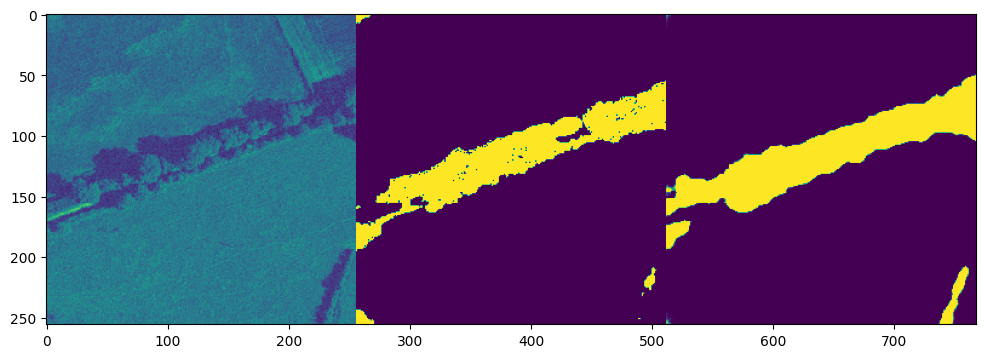

In [188]:
ax, _ = plt.subplots(figsize=(12, 12))
plt.imshow(np.hstack([val_gen.__getitem__(0)[0][idx], val_gen.__getitem__(0)[1][idx], val_preds[idx]]))

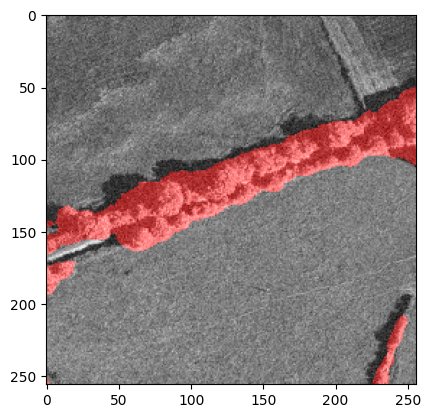

In [189]:
fig = overlay_masks(val_gen.__getitem__(0)[0][idx], np.round(val_preds[idx]), colors=[(1, 0, 0)])
plt.imshow(fig)

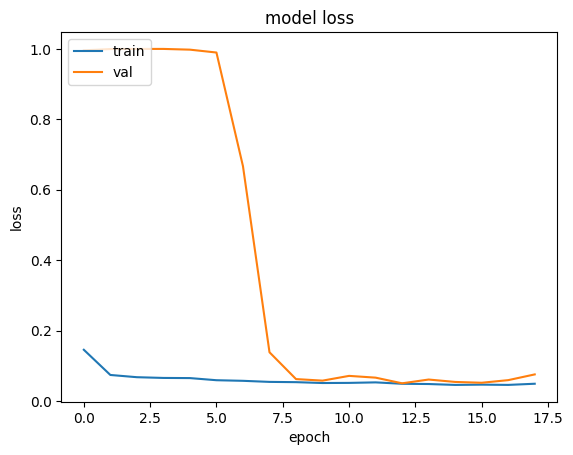

In [132]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

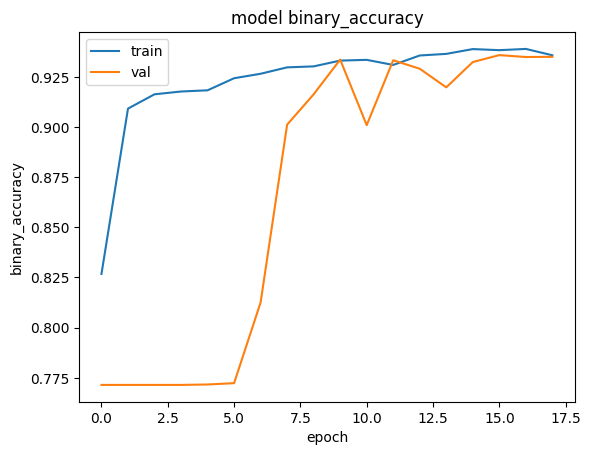

In [25]:
plt.plot(hist.history['binary_accuracy'])
plt.plot(hist.history['val_binary_accuracy'])
plt.title('model binary_accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

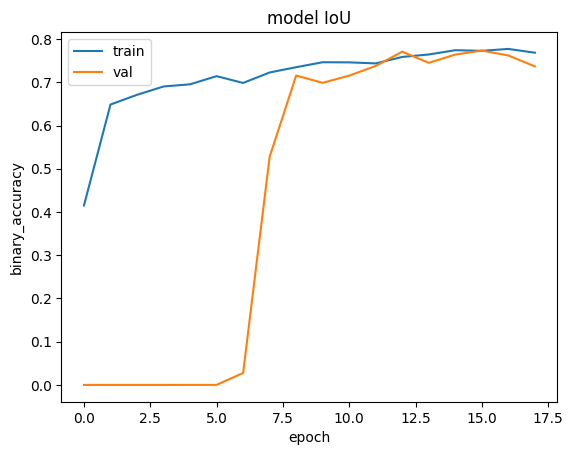

In [26]:
plt.plot(hist.history['io_u'])
plt.plot(hist.history['val_io_u'])
plt.title('model IoU')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
hist.history

{'loss': [0.14555585384368896,
  0.07400448620319366,
  0.06765277683734894,
  0.06556683778762817,
  0.06512975692749023,
  0.05907917767763138,
  0.05737771838903427,
  0.05432650446891785,
  0.053568556904792786,
  0.05112925171852112,
  0.051487475633621216,
  0.05294659361243248,
  0.04900277778506279,
  0.0482625812292099,
  0.045723941177129745,
  0.046532224863767624,
  0.045778848230838776,
  0.04907315969467163],
 'binary_accuracy': [0.8267732262611389,
  0.9092023968696594,
  0.9163331389427185,
  0.9177234172821045,
  0.9183211326599121,
  0.9243409037590027,
  0.926571786403656,
  0.9297623634338379,
  0.9302513003349304,
  0.9331342577934265,
  0.933504045009613,
  0.9309715032577515,
  0.9356826543807983,
  0.9364833235740662,
  0.9388715624809265,
  0.9383330345153809,
  0.9389540553092957,
  0.9357869029045105],
 'io_u': [0.4151017963886261,
  0.6486220359802246,
  0.6710959076881409,
  0.6903265118598938,
  0.6954165101051331,
  0.7142743468284607,
  0.698540210723877

# Loaded model 

In [49]:
from from_preprocessing_to_training import Losses, AttentionUnet
from utils import load_custom_model

In [45]:
losses = Losses()

In [46]:
custom_objects_list=[attention_unet.expend_as, attention_unet.AttnGatingBlock, attention_unet.UnetConv2D, attention_unet.UnetGatingSignal, losses.tversky, losses.focal_tversky]

In [47]:
model_path = 'output_models/intermediary_AttentionUnet_B&W_11988_trains_no_equalizing_with_normalizing_with_1/5_SVD_noise_20_epochs_img_size_256_LR_0_001_BS_32_FocalTverskyLoss_95acc_80iuo.h5'

In [51]:
loaded_model = load_custom_model(model_path=model_path, custom_objects_list=custom_objects_list)


In [52]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv1_1 (Conv2D)            (None, 256, 256, 32)         320       ['input_1[0][0]']             
                                                                                                  
 conv1_1_bn (BatchNormaliza  (None, 256, 256, 32)         128       ['conv1_1[0][0]']             
 tion)                                                                                            
                                                                                                  
 conv1_1_act (Activation)    (None, 256, 256, 32)         0         ['conv1_1_bn[0][0]']      

In [72]:
loaded_model.evaluate(val_gen)

41/41 [==============================] - 127s 3s/step - loss: 0.0409 - binary_accuracy: 0.9496 - io_u: 0.8042


[0.040902651846408844, 0.9496197700500488, 0.8041701316833496]

In [53]:
val_preds_intermediary = loaded_model.predict(val_gen)

41/41 [==============================] - 112s 3s/step


In [70]:
idx = 10

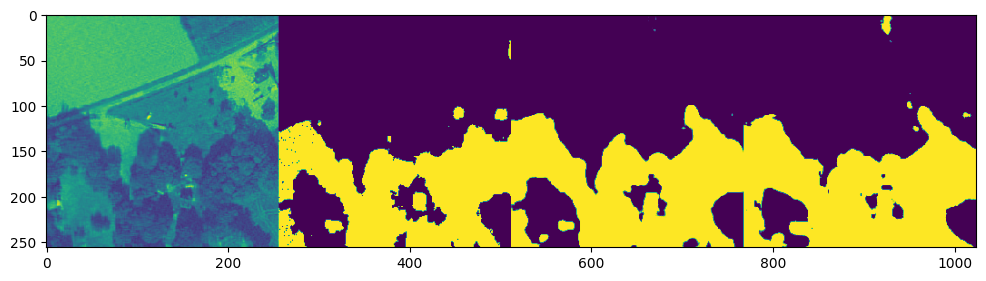

In [71]:
ax, _ = plt.subplots(figsize=(12, 12))
plt.imshow(np.hstack([val_gen.__getitem__(0)[0][idx], val_gen.__getitem__(0)[1][idx], val_preds_intermediary[idx], val_preds[idx]]))

# Stat predictions

In [ ]:
import pandas as pd
df = pd.read_csv('vignettes/stat_older_vignettes.csv', index_col='Unnamed: 0')

# Tests divers